In [19]:
# install dependencies 

# example done for freiburg forest dataset that can be downloaded using the below commands
# wget -c http://deepscene.cs.uni-freiburg.de/static/datasets/freiburg_forest_annotated.tar.gz.part-aa
# wget -c http://deepscene.cs.uni-freiburg.de/static/datasets/freiburg_forest_annotated.tar.gz.part-ab
# wget -c http://deepscene.cs.uni-freiburg.de/static/datasets/freiburg_forest_annotated.tar.gz.part-ac
# cat freiburg_forest_annotated.tar.gz.part-a* > freiburg_forest_annotated.tar.gz



In [20]:
# set variables 

num_labels=6
REPO_NAME = "facebookresearch/dinov2"
MODEL_NAME = "dinov2_vitb14_reg"
root_dir='/workspaces/freiburg_forest_annotated'

# NOTE: I've just put some random ones here, not optimized at all
learning_rate = 5e-5
epochs = 1

# color information for dataset
Color_Information = {
    "unknown_class": {"red_value": 255, "green_value": 0, "blue_value": 0, "class_value": 0},
    "grass": {"blue_value": 0, "green_value": 255, "red_value": 0, "class_value": 1},
    "vegetation": {"blue_value": 51, "green_value": 102, "red_value": 102, "class_value": 2},
    "trail": {"blue_value": 170, "green_value": 170, "red_value": 170, "class_value": 3},
    "sky": {"blue_value": 255, "green_value": 120, "red_value": 0, "class_value": 4},
    "object": {"blue_value": 0, "green_value": 0, "red_value": 0, "class_value": 5}
}

# Convert to Python dictionary
rgb2id = {(info["red_value"], info["green_value"], info["blue_value"]): info["class_value"] for info in Color_Information.values()}
id2rgb = {v: k for k, v in rgb2id.items()}

print("ID to RGB mapping:", id2rgb)
print("RGB to ID mapping:", rgb2id)

import numpy as np
id2color_np = np.array(list(rgb2id.keys()))
print("ID to color mapping:", id2color_np)



ID to RGB mapping: {0: (255, 0, 0), 1: (0, 255, 0), 2: (102, 102, 51), 3: (170, 170, 170), 4: (0, 120, 255), 5: (0, 0, 0)}
RGB to ID mapping: {(255, 0, 0): 0, (0, 255, 0): 1, (102, 102, 51): 2, (170, 170, 170): 3, (0, 120, 255): 4, (0, 0, 0): 5}
ID to color mapping: [[255   0   0]
 [  0 255   0]
 [102 102  51]
 [170 170 170]
 [  0 120 255]
 [  0   0   0]]


# Load Dataset

In [21]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, transforms
from os.path import join
import torch
import numpy as np
import torchvision
import albumentations as A 
from albumentations import Compose, Normalize
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import sys
from transformers.modeling_outputs import SemanticSegmenterOutput
import evaluate
from torch.optim import AdamW
from tqdm.auto import tqdm

torch.cuda.empty_cache()

class SegmentationDataset(Dataset):
    def __init__(self, data_subset, root_dir, rgb2id, transform=None):
        
        self.data_subset = data_subset # train test or val
        self.transform = transform
        self.root = root_dir
        
        # assumes file structure is root/rgb and root/labels
        self.img_dir =  join(self.root, self.data_subset, "rgb")
        self.label_dir = join(self.root, self.data_subset, "GT_color")
        
        # get the number of images in the dataset
        self.num_images = len(os.listdir(self.img_dir))
        # make sure it equals the number of labels
        assert self.num_images == len(os.listdir(self.label_dir))
        
        self.img_labels = [f for f in os.listdir(self.label_dir)]
        
        self.rgb2id = rgb2id

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        img_name, _ = os.path.splitext(self.img_labels[idx])
        
        img_name = img_name.split('_')[0]
        if self.data_subset == 'train':
            label_img_name = img_name + '_mask'
            rgb_img_name = img_name + '_Clipped'
        elif self.data_subset == 'test':
            label_img_name = img_name + '_mask'
            rgb_img_name = img_name + '_Clipped'
        
        
        label_path = None  # Initialize label_path to None
        
        try:
            if os.path.exists(os.path.join(self.label_dir, label_img_name+ '.png')):
                label_path = os.path.join(self.label_dir, label_img_name+ '.png')
            elif os.path.exists(os.path.join(self.label_dir, label_img_name+ '.jpg')):
                label_path = os.path.join(self.label_dir, label_img_name+ '.jpg')
            else:
                # print('label path does not exist for:', os.path.join(self.label_dir, label_img_name))
                return sys.exit()
                # pass
                
        except:
                label_img_name = img_name + '_Clipped'
                if os.path.exists(os.path.join(self.label_dir, label_img_name+ '.png')):
                    label_path = os.path.join(self.label_dir, label_img_name+ '.png')
                elif os.path.exists(os.path.join(self.label_dir, label_img_name+ '.jpg')):
                    label_path = os.path.join(self.label_dir, label_img_name+ '.jpg')
                else:
                    print('label path does not exist for:', os.path.join(self.label_dir, label_img_name))
                    return sys.exit()

        if label_path is None:
            raise ValueError(f"No label file found for image {img_name} in directory {self.label_dir}")


        if os.path.exists(os.path.join(self.img_dir, rgb_img_name+ '.jpg')):
            img_path = os.path.join(self.img_dir, rgb_img_name+ '.jpg')
        elif os.path.exists(os.path.join(self.img_dir, rgb_img_name+ '.png')):
            img_path = os.path.join(self.img_dir, rgb_img_name+ '.png')        
        else:
            print('img path does not exist for:', os.path.join(self.img_dir, rgb_img_name))
            return sys.exit()
            
        image = Image.open(img_path).convert('RGB')
        target = Image.open(label_path).convert('RGB')

        # Resize the image and target to make sure they are the same size
        # use nearest neighbor interpolation to preserve the label ids
        target = target.resize(image.size, Image.NEAREST)

        
        # Convert PIL Image to numpy array
        image = np.array(image)
        target = np.array(target)
        image = image.astype(np.float32)
        
        # result should be between 0 and 1
        image /= 255.0
        
        

        # # Prepare an empty array for the new target
        target_new = np.zeros(target.shape[:2], dtype=np.int32)


        
        
        # # Convert RGB to class id
        
        id2color_np = np.array(list(rgb2id.keys()))
        # Perform the mapping using numpy broadcasting and argmin
        for i, color in enumerate(id2color_np):
            # Find where in the target the current color is
            mask = np.all(target == color, axis=-1)
            
            # Wherever the color is found, set the corresponding index in target_new to the current class label
            target_new[mask] = i
        
        transformed = self.transform(image=image, mask=target_new)
        image, target_new = torch.tensor(transformed['image']), torch.LongTensor(transformed['mask'])
        
        image = image.permute(2,0,1)
        
        return image, target_new

In [22]:

train_transform = A.Compose([
    A.Resize(width=448, height=448),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=448, height=448),
])

train_dataset = SegmentationDataset( root_dir=root_dir, data_subset='train',transform=train_transform, rgb2id=rgb2id)

test_dataset = SegmentationDataset(root_dir=root_dir,data_subset='test', transform=test_transform, rgb2id=rgb2id)


print("train dataset size:", train_dataset.__len__())
print("test dataset size:",test_dataset.__len__())


train dataset size: 230
test dataset size: 136


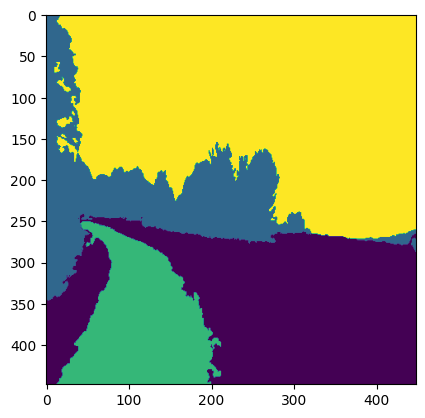

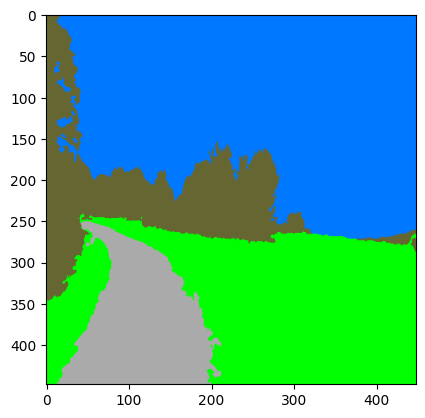

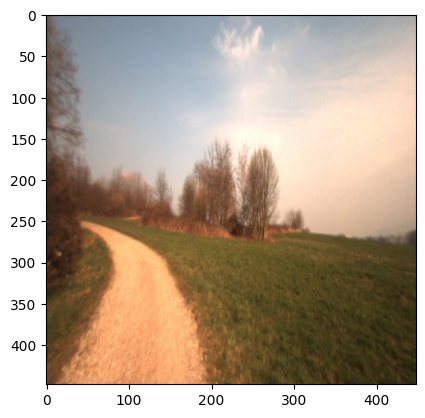

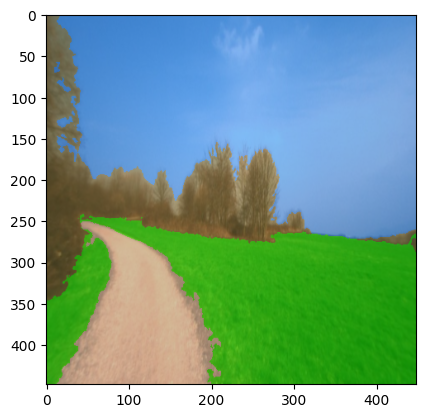

In [23]:

# get an item from the dataset
image, mask = train_dataset[10]
# image, mask = test_dataset[10]
image = image.permute(1,2,0).numpy()

mask_np = mask.detach().cpu().numpy()
color_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
# convert id to rgb values in mask 
for i in range(mask_np.shape[0]):
        for j in range(mask_np.shape[1]):                      

            # Get pixel value
            # pixel_value = segmentation_map[i, j]
            # color_seg[i,j,:] = np.array(id2color[pixel_value])
            pixel_value = int(mask_np[i, j])
            color_mask[i,j,:] = id2color_np[pixel_value]
color_mask = color_mask.astype(np.float32)
color_mask /= 255.0            
            
# visualize the image and mask
plt.imshow(mask)
plt.show()
plt.imshow(color_mask)
plt.show()
plt.imshow(image)
plt.show()

#fuse mask and image into a single image
fused_img = cv2.addWeighted(image, .5, color_mask, 0.5, 0)
plt.imshow(fused_img)





In [24]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

def collate_fn(inputs):


    batch = dict()
    batch["pixel_values"] = torch.stack([i[0] for i in inputs], dim=0)
    batch["labels"] = torch.stack([i[1] for i in inputs], dim=0)

    return batch

# dataloader allows us to get batches of data from the datasets
# batch size and number of workers can be modified to better suit the specs of your machine
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn,num_workers=10)
val_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=10)


In [25]:
# error with this code that will need to be fixed

# load a sample batch of data to make sure eveything is working
batch = next(iter(train_dataloader))


for k,v in batch.items():
  if isinstance(v,torch.Tensor):
    print(k,v.shape)
    
print(batch["pixel_values"].dtype)
print(batch["labels"].dtype)

pixel_values torch.Size([32, 3, 448, 448])
labels torch.Size([32, 448, 448])
torch.float32
torch.int64


In [26]:
# this is the linear classifer that is added to dinov2. It takes in the patch descriptors and outputs data related to the number of labels
class LinearClassifierNew(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearClassifierNew, self).__init__()

        self.in_channels = in_channels # patch descriptor size
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)
    
    
class DinoV2SemanticSegmentationRegisters(torch.nn.Module):
    def __init__(self,  num_labels=1, repo_name="facebookresearch/dinov2", model_name="dinov2_vitb14_reg",   half_precision=False, device="cuda"):
        super().__init__()
        self.repo_name = repo_name
        self.model_name = model_name
        self.half_precision = half_precision
        self.device = device
        
        # load the dinov2 model 
        if self.half_precision:
            self.dinov2 = torch.hub.load(repo_or_dir=repo_name, model=model_name).half().to(self.device)
        else:
            self.dinov2= torch.hub.load(repo_or_dir=repo_name, model=model_name).to(self.device)
        
        # Get the parameters of the last layer
        last_layer_params = list(self.dinov2.parameters())[-1]
        # get the patch descriptor size for use in initializing the linear classifier layer 
        patch_descriptor_size = last_layer_params.shape[0]
        
        # Create the classifier that will be used for semantic segmentation on top of the DINOv2 model
        self.classifier = LinearClassifierNew(patch_descriptor_size, 32, 32, num_labels)
        self.classifier = self.classifier.to(self.device)
        
        # Freeze the DINOv2 model. This allows for faster training. 
        for _, param in self.dinov2.named_parameters():
            param.requires_grad = False
            
            
            
    def __call__(self, pixel_values, labels=None):
        pixel_values = pixel_values.to(self.device)
        if labels is not None:
            labels = labels.to(self.device)
        return self.forward(pixel_values=pixel_values, labels=labels)         
        
    def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
        # Get the embeddings from the DINOv2 model which are patch descriptors
        patch_embeddings = self.dinov2.get_intermediate_layers(pixel_values)[0].squeeze()
            
        # convert to logits and upsample to the size of the pixel values
        logits = self.classifier(patch_embeddings)
        logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

        loss = None
        if labels is not None:
            # important: we're going to use 0 here as ignore index 
            # as we don't want the model to learn to predict background
            loss_fct = torch.nn.CrossEntropyLoss(ignore_index=0)
            loss = loss_fct(logits.squeeze(), labels.squeeze())
        
        return  SemanticSegmenterOutput(
            loss=loss,
            logits=logits
        )

In [27]:
# intialize model
model = DinoV2SemanticSegmentationRegisters(num_labels = num_labels, repo_name=REPO_NAME, model_name=MODEL_NAME, half_precision=False, device="cuda")  

#initialize metrics for model
metric = evaluate.load("mean_iou")
metric_test = evaluate.load("mean_iou")

# set optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# set device for processing and move model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)



Using cache found in /home/dino_user/.cache/torch/hub/facebookresearch_dinov2_main
INFO:dinov2:using MLP layer as FFN


DinoV2SemanticSegmentationRegisters(
  (dinov2): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inp

In [28]:
# initialize empty data stuctures to keep track of learning performance
history_loss_train = []
history_loss_test = []

history_mean_iou_train = []
history_mean_iou_test = []

history_mean_accuracy_train = []
history_mean_accuracy_test = []

# start training
for epoch in range(epochs):
    print("Epoch:", epoch+1)
    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader)):
        torch.cuda.synchronize()
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # forward pass
        outputs = model(pixel_values, labels=labels)
        loss = outputs.loss

        # zero the parameter gradients
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            predicted = outputs.logits.argmax(dim=1)

            # note that the metric expects predictions + labels as numpy arrays
            
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
    
    

  
    metrics = metric.compute(num_labels=num_labels,
                                ignore_index=0,
                                reduce_labels=False,
    )
    history_loss_train.append(loss.item())
    history_mean_iou_train.append(metrics["mean_iou"])
    history_mean_accuracy_train.append(metrics["mean_accuracy"])
    
    model.eval()
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)


        # forward pass
        outputs = model(pixel_values, labels=labels)
        test_loss = outputs.loss

        with torch.no_grad():
            predicted = outputs.logits.argmax(dim=1)

            # note that the metric expects predictions + labels as numpy arrays
            
            metric_test.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

    metrics_test = metric_test.compute(num_labels=num_labels,
                            ignore_index=0,
                            reduce_labels=False,
    )
    history_loss_test.append(test_loss.item())
    history_mean_iou_test.append(metrics_test["mean_iou"])
    history_mean_accuracy_test.append(metrics_test["mean_accuracy"])
    
    print("Train Loss: ", loss.item(), " Test Loss: ", test_loss.item())
    print("Train Mean_iou: ", metrics["mean_iou"], " Test Mean_iou: ", metrics_test["mean_iou"])
    print("Train Mean_accuracy: ", metrics["mean_accuracy"], " Test Mean_accuracy: ", metrics_test["mean_accuracy"])
  
  


Epoch: 1


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
100%|██████████| 8/8 [03:56<00:00, 29.62s/it]
/home/dino_user/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
100%|██████████| 5/5 [02:08<00:00, 25.74s/it]


Train Loss:  1.7318588495254517  Test Loss:  1.7321531772613525
Train Mean_iou:  0.09833600129004177  Test Mean_iou:  0.10758275606948654
Train Mean_accuracy:  0.18659932215591535  Test Mean_accuracy:  0.20535754245139398


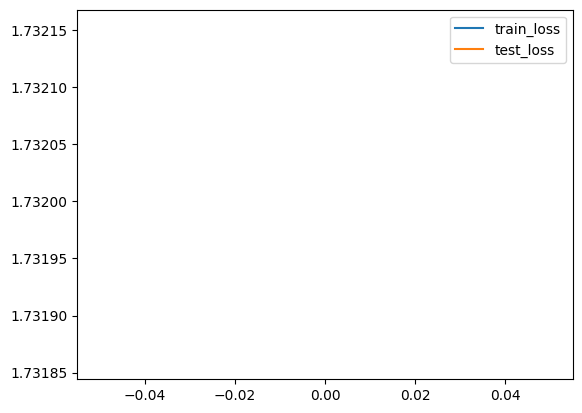

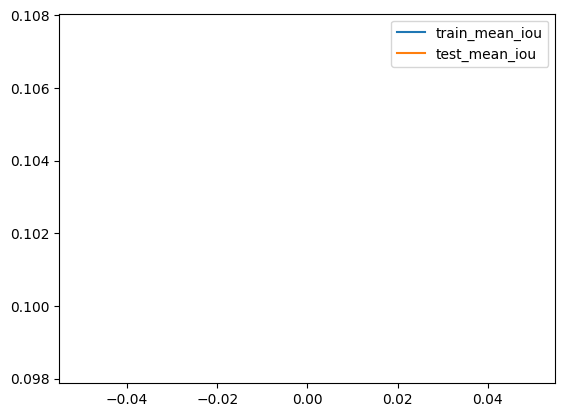

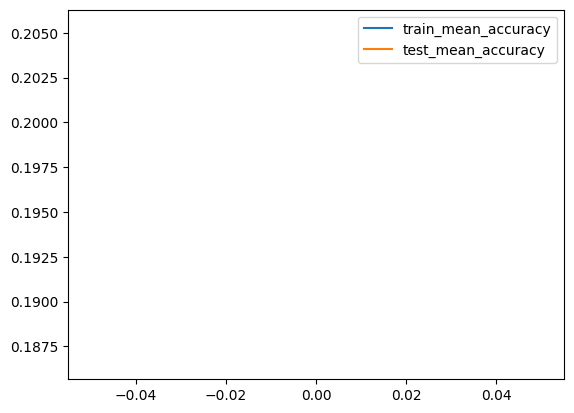

In [29]:
# plot the training and test loss
plt.plot(history_loss_train, label="train_loss")
plt.plot(history_loss_test, label="test_loss")
plt.legend()
plt.show()

# # plot the training and validation mean iou
plt.plot(history_mean_iou_train, label="train_mean_iou")
plt.plot(history_mean_iou_test, label="test_mean_iou")
plt.legend()
plt.show()

# plot the training and validation mean accuracy
plt.plot(history_mean_accuracy_train, label="train_mean_accuracy")
plt.plot(history_mean_accuracy_test, label="test_mean_accuracy")
plt.legend()
plt.show()

/tmp/ipykernel_11250/347444898.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.tensor(test_image)


torch.Size([1, 3, 448, 448])


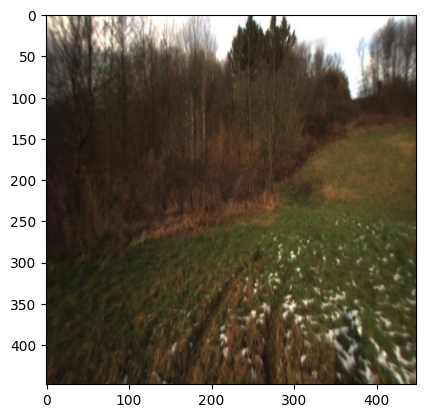

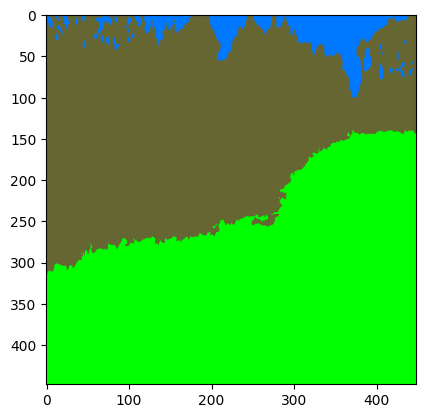

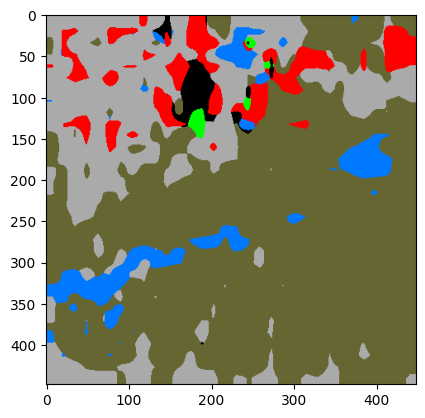

In [31]:
from PIL import Image

test_image, test_mask = test_dataset[7]
img_permute = test_image.permute(1, 2, 0)


pixel_values = torch.tensor(test_image)
pixel_values = pixel_values.unsqueeze(0) # convert to (batch_size, num_channels, height, width)
print(pixel_values.shape)

with torch.no_grad():
  outputs = model(pixel_values.to(device))

upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                   size=(test_image.shape[-2], test_image.shape[-1]),
                                                   mode="bilinear", align_corners=False)

predicted_map = upsampled_logits.argmax(dim=1)



plt.imshow(img_permute)
plt.show()






mask_np = test_mask.detach().cpu().numpy()
color_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
# convert id to rgb values in mask 
for i in range(mask_np.shape[0]):
        for j in range(mask_np.shape[1]):                      

            # Get pixel value
            # pixel_value = segmentation_map[i, j]
            # color_seg[i,j,:] = np.array(id2color[pixel_value])
            pixel_value = int(mask_np[i, j])
            color_mask[i,j,:] = id2color_np[pixel_value]
color_mask = color_mask.astype(np.float32)
color_mask /= 255.0            
            

plt.imshow(color_mask)
plt.show()

mask_np = predicted_map.squeeze().detach().cpu().numpy()
color_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
# convert id to rgb values in mask 
for i in range(mask_np.shape[0]):
        for j in range(mask_np.shape[1]):                      

            # Get pixel value
            # pixel_value = segmentation_map[i, j]
            # color_seg[i,j,:] = np.array(id2color[pixel_value])
            pixel_value = int(mask_np[i, j])
            color_mask[i,j,:] = id2color_np[pixel_value]
color_mask = color_mask.astype(np.float32)
color_mask /= 255.0  

plt.imshow(color_mask)
plt.show()
